# Stylometry - model training

### Used classifiers
 - Decision Tree
 - kNN (NYI)
 - SVM (NYI)
 
 
 - ? Logistic Regression (NYI)

## Imports

In [5]:
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from numpy import mean
from numpy import average
from numpy import absolute
from numpy import sqrt
from numpy import std
from sklearn import preprocessing
import statistics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.impute import KNNImputer
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
# from skmultilearn.model_selection import IterativeStratification
from sklearn.linear_model import LogisticRegression
import gc
import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def scale(df_to_scale, ignored_cols):
    cols_to_scale = df_to_scale.drop(ignored_cols , axis=1).columns
    min_max_scaler = MinMaxScaler()
    df_to_scale[cols_to_scale] = min_max_scaler.fit_transform(df_to_scale[cols_to_scale])
    df.info()
    return df_to_scale

In [3]:
def evaluate(real, predicted):
    print("Evaluation: ")
    countGood = 0
    total = len(real)
    falsePos = 0
    falseNeg = 0
    truePos = 0
    trueNeg = 0
    if total != len(predicted):
        print("Non-matching sample lengths")
        return None
    for i in range(0, total):
        countGood += 1 if real[i] == predicted[i] else 0

    # accuracy = str(countGood / total)
    # precision = str(truePos / (truePos + falsePos))
    # recall = str(truePos / (truePos + falseNeg))
    
    print("accuracy " + str(countGood / total))
    return countGood / total

## Data import
\+calculate positional error occurence per token

In [41]:

df = pd.read_csv('64authors_top3grams_swaps_blogtext_100articles.csv', sep=',')
df['Toperror_pertokens'] = df['Toperror'] / df['Tokens']
df['Lefterror_pertokens'] = df['Lefterror'] / df['Tokens']
df['Righterror_pertokens'] = df['Righterror'] / df['Tokens']
df['Downerror_pertokens'] = df['Downerror'] / df['Tokens']
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Columns: 2304 entries, Author to Downerror_pertokens
dtypes: float64(1112), int64(1192)
memory usage: 112.5 MB


,Author,UppercaseLetter,UppercaseLetter_pertokens,LowercaseLetter,LowercaseLetter_pertokens,TitlecaseLetter,TitlecaseLetter_pertokens,ModifierLetter,ModifierLetter_pertokens,OtherLetter,...,swap_ _m,swap_ _CO,swap_ _.,swap_ _/,swap_ _,Tokens,Toperror_pertokens,Lefterror_pertokens,Righterror_pertokens,Downerror_pertokens
0,13,38,1.226,60,1.935,0,0,0,0,0,...,0,0,0,0,0,31,0.0,0.064516,0.000000,0.000000
1,13,12,0.286,125,2.976,0,0,0,0,0,...,0,0,0,0,0,42,0.0,0.023810,0.000000,0.000000
2,13,25,0.150,582,3.485,0,0,0,0,0,...,0,0,0,0,0,167,0.0,0.023952,0.035928,0.005988


In [42]:
df = df.replace("∞", "0")

In [43]:
# df_all = scale(df, ["Author", "Tokens"])
df_all = df
df_all

,Author,UppercaseLetter,UppercaseLetter_pertokens,LowercaseLetter,LowercaseLetter_pertokens,TitlecaseLetter,TitlecaseLetter_pertokens,ModifierLetter,ModifierLetter_pertokens,OtherLetter,...,swap_ _m,swap_ _CO,swap_ _.,swap_ _/,swap_ _,Tokens,Toperror_pertokens,Lefterror_pertokens,Righterror_pertokens,Downerror_pertokens
0,13,38,1.226,60,1.935,0,0,0,0,0,...,0,0,0,0,0,31,0.000000,0.064516,0.000000,0.000000
1,13,12,0.286,125,2.976,0,0,0,0,0,...,0,0,0,0,0,42,0.000000,0.023810,0.000000,0.000000
2,13,25,0.150,582,3.485,0,0,0,0,0,...,0,0,0,0,0,167,0.000000,0.023952,0.035928,0.005988
3,13,64,0.174,1188,3.228,0,0,0,0,0,...,0,0,0,0,0,368,0.000000,0.000000,0.000000,0.000000
4,13,16,0.099,590,3.665,0,0,0,0,0,...,0,0,0,0,0,161,0.006211,0.031056,0.024845,0.006211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,19174,28,0.168,554,3.317,0,0,0,0,0,...,0,0,0,0,0,167,0.000000,0.000000,0.000000,0.000000
6396,19174,63,0.123,1878,3.654,0,0,0,0,0,...,0,0,0,0,0,514,0.000000,0.005837,0.009728,0.000000
6397,19174,73,0.124,2052,3.484,0,0,0,0,0,...,0,0,0,0,0,589,0.000000,0.003396,0.010187,0.000000
6398,19174,39,0.166,775,3.298,0,0,0,0,0,...,0,0,0,0,0,235,0.000000,0.004255,0.000000,0.004255


In [44]:
len(df_all['Author'].unique())

64

## Dataframes
df_all - contains all feature columns and author id

df_positional - contains positional errors, token count, misspell ratio and author id

non_empty_cols - all columns with non-zero values

In [45]:
# filtered_suff = []
# for x in df_all.columns:
#     if x.endswith("_pertokens"):
#         filtered_suff.append(x)
# filtered_suff.sort()
# for x in filtered_suff:
#     print(x)
#     print(mean(df_all[x]))

In [200]:
all_cols = df_all.columns
to_add_cols = [  'Author',
                 'CurrencySymbol_pertokens',
                 'ConnectorPunctuation_pertokens',
                 'Control_pertokens',
#                  'Downerror_pertokens',
                 'DecimalDigitNumber_pertokens',
                 'FinalQuotePunctuation_pertokens',
                 'InitialQuotePunctuation_pertokens',
                 'LowercaseLetter_pertokens',
#                  'Lefterror_pertokens',
                 'MathSymbol_pertokens',
#                  'Misspellratio',
                 'OtherLetter_pertokens',
                 'OtherNotAssigned_pertokens',
                 'OtherPunctuation_pertokens',
#                  'Righterror_pertokens',
                 'SpaceSeparator_pertokens',
#                  'Toperror_pertokens',
                 'UppercaseLetter_pertokens'
              ]
# to_add_cols = [  'Author',
#                  'Misspellratio']
# to_add_cols = [  'Author',
#                  'Lefterror_pertokens',
#                  'Righterror_pertokens',
#                  'Downerror_pertokens',
#                  'Toperror_pertokens']
# to_add_cols = ['Author']


# filter out empty columns and add selected feature sets
# available prefixes in feature sets - 'pos_' 'swap_'
prefixes = ['pos_']
# prefixes = []
for col in all_cols:
    if (not((df_all[col] == 0).all()) and any(col.startswith(x) for x in prefixes)):
        to_add_cols.append(col)
df_positional = df_all[to_add_cols]
len(df_positional.columns)

311

### Filtering
removing NaN and inf values

In [201]:
df_positional.dropna()
indices_to_keep = ~df_positional.isin([np.nan, np.inf, -np.inf]).any(1)
df_positional = df_positional[indices_to_keep].astype(np.float64)
df_positional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 0 to 6399
Columns: 311 entries, Author to pos_296_CD_NN_VB
dtypes: float64(311)
memory usage: 15.2 MB


## OPTIONAL 
+ used to reduce the number of authors, to create the same samples as in other articles


In [202]:
# Exploiting SI for AA - 480 texts, 11 authors
count_authors = 4
count_samples = 200


# split_index = len(df_all)/2
# count_samples = len(df_all)

print(len(df_positional["Author"].unique()))

all_authors = df_all["Author"].unique()
split_authors = np.random.choice(all_authors, size=count_authors + 1)
df_positional = df_positional[df_positional["Author"].isin(split_authors)]

print(len(df_positional["Author"].unique()))
df_positional = df_positional.sample(count_samples)

64
5


# Split to train/test
- no split needed if using cross validation - percentage_to_train should be 1.0

In [203]:
data_count = len(df_positional)
percentage_to_train = 0.7
df_train = df_positional.sample(int(data_count*(percentage_to_train)))
df_test = pd.concat([df_train, df_positional]).drop_duplicates(keep=False)
# df_test = df_positional[int(data_count*2/3):]
df_train.info()
df_test.info()
print(data_count)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 927 to 956
Columns: 311 entries, Author to pos_296_CD_NN_VB
dtypes: float64(311)
memory usage: 341.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 1271 to 1249
Columns: 311 entries, Author to pos_296_CD_NN_VB
dtypes: float64(311)
memory usage: 146.2 KB
200


### Split training into features and labels

In [204]:
X = df_train.drop('Author', axis=1)
y = df_train["Author"]
len(X)

140

In [205]:
cv = KFold(n_splits=30, random_state=1, shuffle=True)

# Model fitting
### Decision Tree Classifier
Create a decision tree classifier and get predictions on the same dataset

In [206]:
dt = tree.DecisionTreeClassifier()
# dt = dt.fit(X, y)
dt_acc = cross_validate(dt, X, y, scoring='accuracy', cv=cv, n_jobs=1)
# dt_rmse = cross_validate(dt, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

### Random forest

In [207]:
forest=RandomForestClassifier(n_estimators=200)
# forest.fit(X,y)
forest_acc = cross_validate(forest, X, y, scoring='accuracy', cv=cv, n_jobs=1)
# forest_rmse = cross_validate(forest, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

In [208]:
# forest=RandomForestClassifier(n_estimators=200)
# forest.fit(X,y)

# Evaluation
- mean accuracy
- std of accuracy
- rmse

In [209]:
print("Decision tree")
print(mean(dt_acc['test_score']))
print(std(dt_acc['test_score']))
# print(mean(dt_rmse['test_score']))
# print(dt_acc)
# print("Logreg")
# print(logreg_acc)
print("Forest")
print(mean(forest_acc['test_score']))
print(std(forest_acc['test_score']))
# print(mean(forest_rmse['test_score']))
# print(forest_acc)

Decision tree
0.42166666666666663
0.1869417615788998
Forest
0.44333333333333336
0.25714241622537154


In [210]:
X_test = df_test.drop('Author', axis=1)
Y_test = df_test['Author'].to_numpy()

## DT

In [211]:
# Decision Tree
# predictions_dt = dt.predict(X_test)
# dt_acc = evaluate(Y_test, predictions_dt)

### Random Forest

In [212]:
predictions_forest = forest.predict(X_test)
forest_acc = evaluate(Y_test, predictions_forest)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Other -------- UNRELATED -------
under construction

In [124]:
# Feature importance for random forest
fi = pd.DataFrame({'feature': list(X.columns),
                   'importance': forest_acc['estimator'][0].feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(20)

TypeError: 'float' object is not subscriptable

## Automatic feature selection

In [228]:
# def select_features(df, k=5):
#     df_new = df.drop(["Author"], axis=1)
#     indicators_indexed = []
#     for x in df['Author']:
#         indicators_indexed.append(x)
# #     print(len(indicators_indexed))
#     # print(df_normal)
#     np.random.seed(1)
#     selector = SelectKBest(chi2, k=k)
# #     selector = SelectKBest(mutual_info_regression, k=k)
#     k_best_features = selector.fit_transform(df_new.values, indicators_indexed)
#     print(selector.get_support(1))
#     return (k_best_features, selector.get_support())

In [229]:
# feat, mask = select_features(df_train, 6)

# new_features = df_train.drop(["Author"], axis=1).columns[mask]
# new_features
# # print(ind)
# df_positional = df_all[new_features]
# df_positional["Author"] = df_all["Author"]
# df_positional.info()

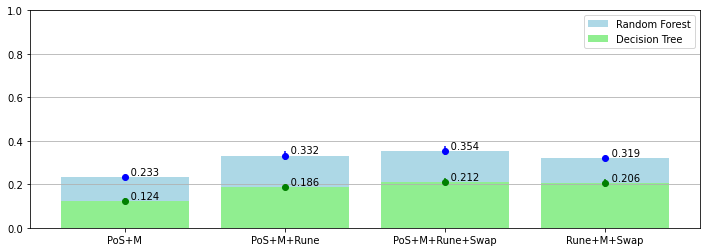

In [21]:
import numpy as np
import matplotlib.pyplot as plt
# Schler results
# df_viz = pd.DataFrame({'accuracy_dt': [  0.21458333333333335,
#                                          0.39166666666666666,
#                                          0.39375,
#                                          0.4125
#                                       ],
#                        'std_dt':      [  0.061130836463005045,
#                                          0.055746200667748554,
#                                          0.05547302898205977,
#                                          0.07144345083117601
#                                       ],
                       
#              'accuracy_forest': [0.375,
#                                  0.54375,
#                                  0.5916666666666667,
#                                  0.525
#                                 ],
#              'std_forest': [     0.04564354645876384,
#                                  0.07123050415532817,
#                                  0.059802917060030526,
#                                  0.0832291014809924
#                            ],
                       
#              'feature_sets': [  'PoS+M',
#                                 'PoS+M+Rune',
#                                 'PoS+M+Rune+Swap',
#                                 'Rune+M+Swap'],
#                       })

# 64 authors, 100 texts per author
df_viz = pd.DataFrame({'accuracy_dt': [  0.12378643388106417,
                                         0.18615585876369325,
                                         0.21194811228482005,
                                         0.20646933685446012
                                      ],
                       'std_dt':      [  0.01393656059439675,
                                         0.00957214614515149,
                                         0.01568375570895567,
                                         0.019806577268027568
                                      ],
                       
             'accuracy_forest': [0.23320080203442878,
                                 0.33198503521126765,
                                 0.35449041471048515,
                                 0.3193163145539906
                                ],
             'std_forest': [     0.01049702279841128,
                                 0.01974326428687065,
                                 0.021420555668516937,
                                 0.012759292892852388
                           ],
                       
             'feature_sets': [  'PoS+M',
                                'PoS+M+Rune',
                                'PoS+M+Rune+Swap',
                                'Rune+M+Swap'],
                      })

fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
plt.ylim(0, 1)

plt.bar(df_viz['feature_sets'], df_viz['accuracy_forest'], color='lightblue')
plt.bar(df_viz['feature_sets'], df_viz['accuracy_dt'], color='lightgreen')
plt.errorbar(df_viz['feature_sets'], df_viz['accuracy_forest'], color='blue', yerr=df_viz['std_forest'], fmt='o')
plt.errorbar(df_viz['feature_sets'], df_viz['accuracy_dt'], color='green', yerr=df_viz['std_dt'], fmt='o')

ax.bar_label(ax.containers[0], fmt="             %.3g")
ax.bar_label(ax.containers[1], fmt="             %.3g")
ax.legend(['Random Forest', 'Decision Tree'])
ax.yaxis.grid(True)
plt.show()


6400


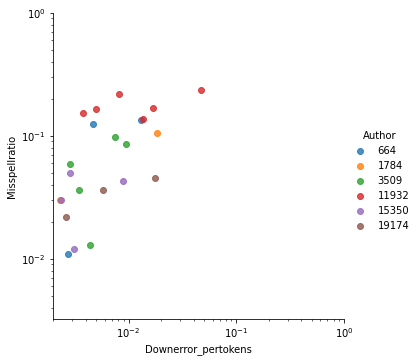

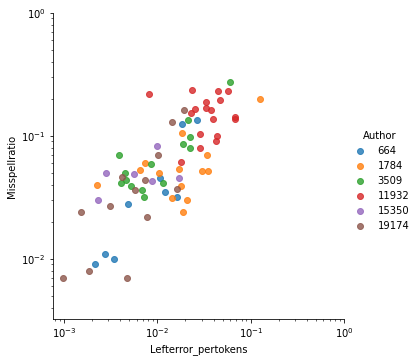

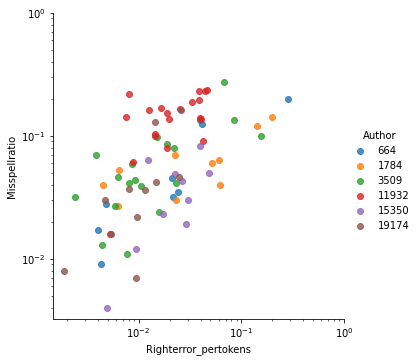

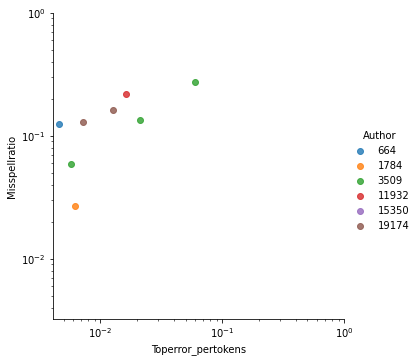

In [97]:
df_viz = df_all
print(len(df_viz))

all_authors = df_all["Author"].unique()
split_authors_viz = np.random.choice(all_authors, size=6)
df_viz = df_viz[df_viz["Author"].isin(split_authors_viz)]
df_viz = df_viz.sample(int(len(df_viz)/4))
sns.set_palette("tab10")
viz_cols = [  'Downerror_pertokens',
              'Lefterror_pertokens',
              'Righterror_pertokens',
              'Toperror_pertokens',
              ]

for x in viz_cols:
    grid = sns.lmplot(x, 'Misspellratio', data=df_viz, hue='Author', fit_reg=False)
    grid.set(xscale="log", yscale="log").set(xlim=(0,1),ylim=(0,1))
    fig = grid.fig
    fig.savefig('figures/64authors_top3grams_swaps_blogtext_100articles_Misspellratio_'+str(x)+'.png')

